# Logistic Regression

### Data Preprocessing

In [ ]:
# Imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Import the data cleaning function
scripts_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, scripts_directory)
from scripts import data_cleaning

In [ ]:
# Load in the test set
data = pd.read_csv("../data/train.csv", engine="python", on_bad_lines="skip")

# Apply the data cleaning function
data_clean = data_cleaning.clean_data(data)

In [3]:
# Extract a smaller sample size of the data 
sample_data, unused = train_test_split(data_clean, train_size=1000, stratify=data_clean['rating_rejected'], random_state=42)

In [4]:
# Separate the features and target variable
X = sample_data.drop("rating_rejected", axis=1)
y = sample_data['rating_rejected']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [5]:
# Initialize a scaler
scaler = StandardScaler()

# Initialize comment converter
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))

# Apply column transformation for comments and scaling for other variables
text_col = "comment_text"
num_cols = X.drop(columns=["comment_text"]).columns.tolist()
transformers = [
    ("text", tfidf, text_col), 
    ("num", scaler, num_cols)]
transform = ColumnTransformer(transformers)

# Initialize a logistic regression object
log_reg = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, random_state=42)

# Make data processing pipeline
steps = [
    ('transform', transform),
    ('log_reg', log_reg)
    ]

regression_pip = Pipeline(steps)

In [6]:
# Define hyperparameters to tune
c = [0.1, 1, 10, 100]
l1_ratio = [0, 0.1, 0.5, 0.9, 1.0]

params = {'log_reg__C': c, 'log_reg__l1_ratio': l1_ratio}

# Define scoring metrics
scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

### Model Training and Optimization

In [7]:
# Define the grid search object for cross validation and hyperparameter tuning
grid = GridSearchCV(regression_pip, params, cv=4, scoring=scoring, refit='accuracy', n_jobs=-1)

In [9]:
# Run the grid search
grid.fit(X_train, y_train)

,estimator,Pipeline(step...ver='saga'))])
,param_grid,"{'log_reg__C': [0.1, 1, ...], 'log_reg__l1_ratio': [0, 0.1, ...]}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1'}"
,n_jobs,-1
,refit,'accuracy'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('text', ...), ('num', ...)]"


### Evaluate Performance 

In [10]:
# Analyze grid search results

grid_results = grid.cv_results_

grid_df = pd.DataFrame(grid_results)
grid_df['total_time'] = (grid_df['mean_fit_time'] + grid_df['mean_score_time']) * 4
columns = ['total_time', 'param_log_reg__C', 'param_log_reg__l1_ratio', 'mean_test_accuracy', 'mean_test_f1', 'rank_test_accuracy']
grid_df = grid_df[columns]

column_names = {
    'total_time': 'Time',
    'param_log_reg__C': 'C',
    'param_log_reg__l1_ratio': 'L1 Ratio',
    'mean_test_accuracy': 'Accuracy',
    'mean_test_f1': 'F1 Score',
    'rank_test_accuracy': 'Rank'}
grid_df = grid_df.rename(columns=column_names)

grid_df = grid_df.sort_values(by='Rank')

print("Model Results Table")
print(grid_df)


Model Results Table
          Time      C  L1 Ratio  Accuracy  F1 Score  Rank
3     5.848907    0.1       0.9   0.93250  0.000000     1
4     6.338031    0.1       1.0   0.93250  0.000000     1
2     7.636512    0.1       0.5   0.93000  0.000000     3
15    8.577098  100.0       0.0   0.92875  0.033333     4
19  297.020788  100.0       1.0   0.92875  0.033333     4
18  325.994572  100.0       0.9   0.92875  0.033333     4
17  469.204318  100.0       0.5   0.92875  0.033333     4
16  813.761699  100.0       0.1   0.92875  0.033333     4
10    6.821486   10.0       0.0   0.92750  0.000000     9
14   71.745153   10.0       1.0   0.92750  0.090074     9
11  310.441505   10.0       0.1   0.92750  0.000000     9
0     5.747501    0.1       0.0   0.92625  0.000000    12
8     9.832438    1.0       0.9   0.92625  0.029412    12
7     9.639618    1.0       0.5   0.92625  0.029412    12
5     8.055019    1.0       0.0   0.92625  0.029412    12
1     6.127983    0.1       0.1   0.92625  0.000000 

In [11]:
# Evaluate information from the best model

best_model = grid.best_estimator_
best_params = grid.best_params_
best_C = best_params['log_reg__C']
best_l1_ratio = best_params['log_reg__l1_ratio']
best_score = grid.best_score_
best_model_index = grid.best_index_

print("Optimal Model")
print("Accuracy Score:", best_score)
print("L1 Ratio:", best_l1_ratio)
print("Regularization Strength (C):", best_C)

Optimal Model
Accuracy Score: 0.9325000000000001
L1 Ratio: 0.9
Regularization Strength (C): 0.1


In [13]:
# Calculate performance metrics for the best model on the validation set
pred_best = best_model.predict(X_val)

acc = accuracy_score(y_val, pred_best)
f1 = f1_score(y_val, pred_best)
class_report = classification_report(y_val, pred_best)

print("Accuracy Score:", acc)
print("F1 Score:", f1)
print("Classification Report:\n", class_report)

Accuracy Score: 0.94
F1 Score: 0.0
Classification Report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97       188
        True       0.00      0.00      0.00        12

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.88      0.94      0.91       200



/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

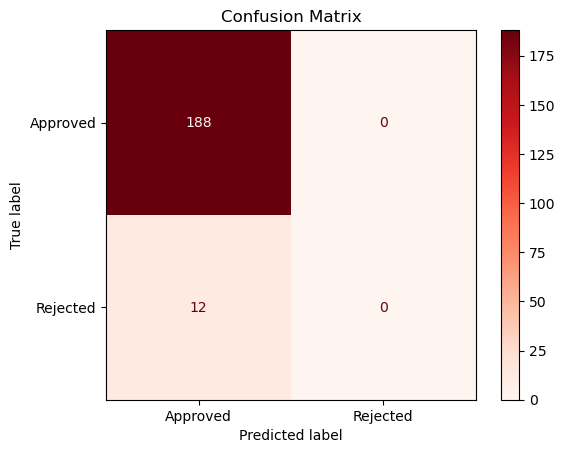

In [15]:
# Produce and display a Confusion Matrix
cm = confusion_matrix(y_val, pred_best)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Approved', 'Rejected'])
cm_display.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

### Summary of Results

Overall, the logistic regression model does not perform well for classifying rejected toxic comments. Looking at accuracy alone, it scores well because it is able to predict the majority class of non-rejected comments. However, it severely falls short in identifying the target class of comments that were rejected. This explains the relatively high accuracy scores but the low F1 scores for each model. This scoring metric imbalance occurs because the dataset has a significantly greater amount of non-rejected comments than rejected comments, skewing the predictions to a single label. Hyperparameter tuning does not have much of an effect on model performance because this regression model consistently predicted the majority class.